In [439]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
sns.set()

Working with numeric variables first

In [174]:
conn = sqlite3.connect("champion_riot.sqlite")
cur = conn.cursor()

In [363]:
# all tables in the database champion_riot_sqlite
pd.read_sql_query("""SELECT name FROM sqlite_master
                     WHERE type='table'
                     ORDER BY name;""", conn)

,name
0,allytips
1,blurb
2,enemytips
3,format
4,info
5,partype
6,passive
7,skins
8,spells
9,stats


In [176]:
df = pd.read_sql_query("""SELECT a.title, a.id, a.name, b.difficulty, b.attack, b.defense, b.magic
                          FROM allytips a 
                          LEFT JOIN (SELECT * FROM info) b 
                          ON a.id = b.id""", conn)

In [177]:
# a total of 137 champions are currently in the game
df.shape

(137, 7)

In [178]:
# all info ranges from 1 to 10
df[["difficulty","attack","defense","magic"]].aggregate(["min","mean","median","max"])

,difficulty,attack,defense,magic
min,1.000000,1.000000,1.000000,1.000000
mean,5.751825,5.540146,4.773723,5.423358
median,6.000000,6.000000,5.000000,6.000000
max,10.000000,10.000000,10.000000,10.000000


In [179]:
df[["difficulty","attack","defense","magic"]].corr(method='pearson')

,difficulty,attack,defense,magic
difficulty,1.000000,-0.194008,-0.310971,0.308174
attack,-0.194008,1.000000,-0.178120,-0.828016
defense,-0.310971,-0.178120,1.000000,-0.131800
magic,0.308174,-0.828016,-0.131800,1.000000


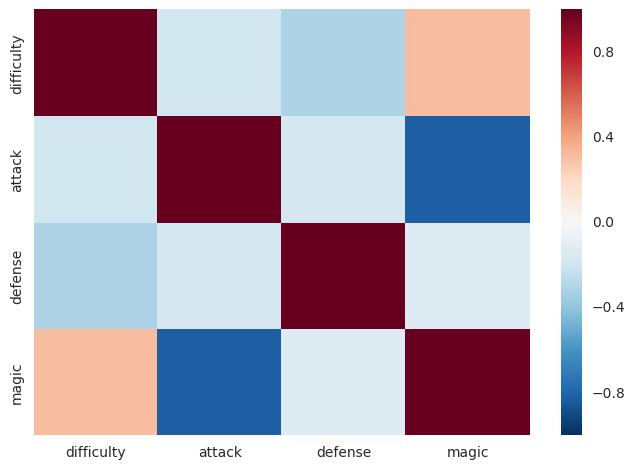

In [180]:
sns.heatmap(df[["difficulty","attack","defense","magic"]].corr(method='pearson'))
plt.show()

In [181]:
print(scipy.stats.pearsonr(df["difficulty"], df["attack"])) # significant weak negative correlation
print(scipy.stats.pearsonr(df["difficulty"], df["defense"])) # significant weak negative correlation
print(scipy.stats.pearsonr(df["difficulty"], df["magic"])) # significant weak positive correlation

(-0.19400783573555302, 0.023109157613865467)
(-0.31097050809761989, 0.00021679150909228914)
(0.3081741957747251, 0.00024867946587844831)


In [182]:
print(scipy.stats.pearsonr(df["attack"], df["defense"])) # significant weak negative correlation
print(scipy.stats.pearsonr(df["attack"], df["magic"])) # significant strong negative correlation

(-0.17811991342786959, 0.03730409391972505)
(-0.82801553843011422, 9.9003928907948432e-36)


In [183]:
print(scipy.stats.pearsonr(df["defense"], df["magic"])) # Not significant weak negative correlation

(-0.13179968744554141, 0.1247233505738516)


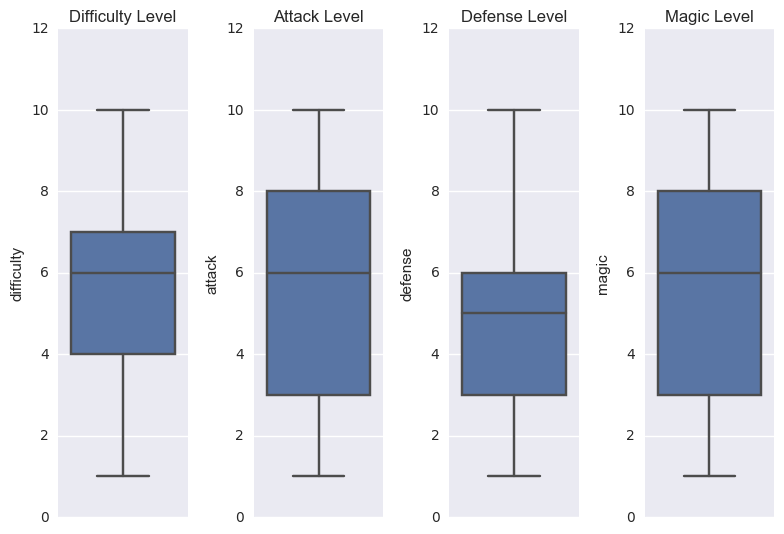

In [184]:
plt.subplot(1, 4, 1)
plt.title("Difficulty Level")
sns.boxplot(df["difficulty"],orient = "v")
plt.ylim([0 , 12])
plt.subplot(1, 4, 2)
plt.title("Attack Level")
sns.boxplot(df["attack"],orient = "v")
plt.ylim([0 , 12])
plt.subplot(1, 4, 3)
plt.title("Defense Level")
sns.boxplot(df["defense"],orient = "v")
plt.ylim([0 , 12])
plt.subplot(1, 4, 4)
plt.title("Magic Level")
sns.boxplot(df["magic"],orient = "v")
plt.ylim([0 , 12])
plt.tight_layout()
plt.show()

Difficulty, attack, defense, and magic levels were all on a scale of 1 to 10. difficulty, attack, and magic had a medium around 6, while defense has the lowest medium at 5 - the distribution of defense was also lowered than the others. Defense and difficulty levels were negatively associated with each other (-0.31). Difficulty was positively related to magic (0.31). Attack was strongly negatively associated with magic (-0.83). Only difficulty and magic is negatively correlated with each other. 

In [185]:
# all champions have a format of full - skip format
pd.read_sql_query("""SELECT * FROM format""", conn)["format"].value_counts()

full    137
Name: format, dtype: int64

In [186]:
# partype data 
df1 = pd.read_sql_query("""SELECT * FROM partype""", conn)

In [187]:
df1.head(3)

,partype,id
0,Mana,1
1,Mana,10
2,Mana,101


In [188]:
graph = df1["partype"].value_counts().reset_index()

In [189]:
graph["percent"] = graph["partype"]/137.*100

In [190]:
graph

,index,partype,percent
0,Mana,115,83.941606
1,Energy,5,3.649635
2,None,5,3.649635
3,Fury,4,2.919708
4,Blood Well,1,0.729927
5,Flow,1,0.729927
6,Ferocity,1,0.729927
7,Heat,1,0.729927
8,Rage,1,0.729927
9,Crimson Rush,1,0.729927


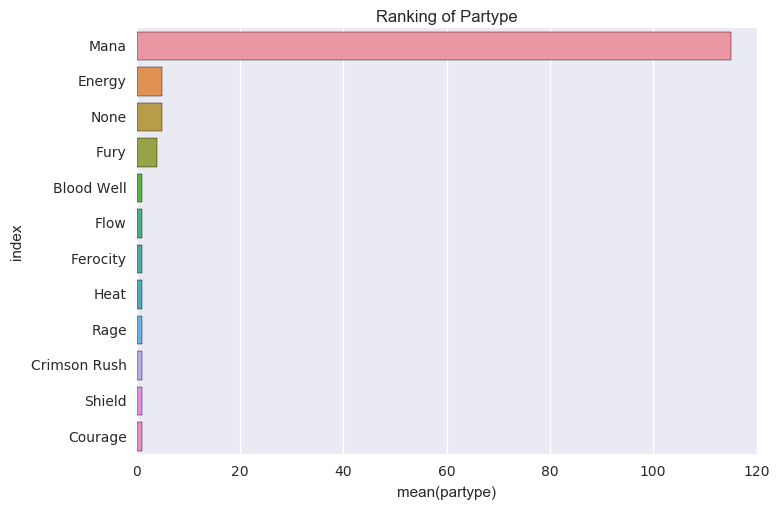

In [191]:
sns.barplot(y = "index", x = "partype", data = graph, orient = "h")
plt.title("Ranking of Partype")
plt.show()

The most prevalent types were mana (84%), energy (4%), none (4%), and fury (3%). All other types only had one hero (< 1%)

In [192]:
df = pd.merge(df, df1, how = "inner", on = "id")

In [193]:
df2 = pd.read_sql_query("""SELECT id, no_skins FROM skins""", conn)

In [194]:
df2["no_skins"].aggregate(["min","mean","median","max"])

min        2.000000
mean       6.671533
median     7.000000
max       11.000000
Name: no_skins, dtype: float64

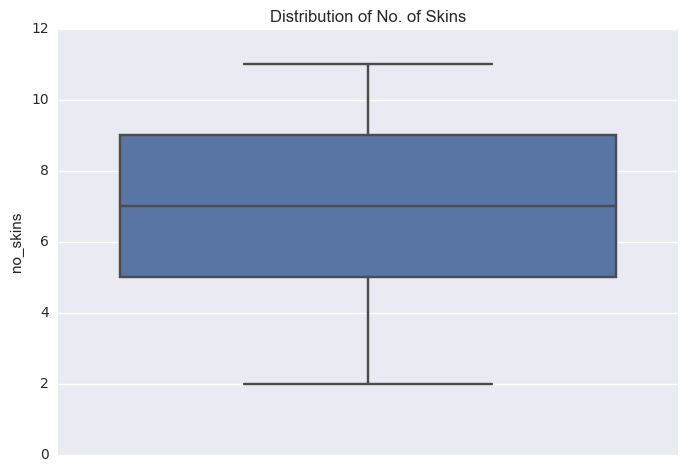

In [195]:
sns.boxplot(y = "no_skins", data = df2)
plt.ylim([0,12])
plt.title("Distribution of No. of Skins")
plt.show()

In [196]:
df = pd.merge(df, df2, how = "inner", on = "id")

In [197]:
df.head(2)

,title,id,name,difficulty,attack,defense,magic,partype,no_skins
0,the Dark Child,1,Annie,6,2,3,10,Mana,11
1,The Judicator,10,Kayle,7,6,6,7,Mana,9


On average, each character has 7 skins. The no ranges from 2 to 11. 

In [364]:
df3 = pd.read_sql_query("""SELECT *
                           FROM stats""", conn)

In [365]:
list(df3)
# starting stats: attack damage, mp, armor, hp, attack range, move speed, crit, mpregen, 
# spellblock, hpreg, attackspeed offset
# leveling up stats: attackdamagerperlevel, mpperlevel, armorperlevel, hpperlevel, critperlevel, 
# mpregenperlevel, spellblockperlevel, hpregperlvel, attackspeedperlevel

['id',
 'armorperlevel',
 'attackdamage',
 'mpperlevel',
 'attackspeedoffset',
 'mp',
 'armor',
 'hp',
 'hpregenperlevel',
 'attackspeedperlevel',
 'attackrange',
 'movespeed',
 'attackdamageperlevel',
 'mpregenperlevel',
 'critperlevel',
 'spellblockperlevel',
 'crit',
 'mpregen',
 'spellblock',
 'hpregen',
 'hpperlevel']

In [217]:
# HP - hp, hpperleevel, hpregen, hprenperlel
df3[["hp","hpperlevel","hpregen","hpregenperlevel"]].aggregate(["min","median","mean","max"])

,hp,hpperlevel,hpregen,hpregenperlevel
min,340.000000,65.000000,2.50000,0.300000
median,550.000000,85.000000,6.92400,0.600000
mean,549.363796,84.337591,6.88762,0.656934
max,625.640000,106.000000,10.18000,1.750000


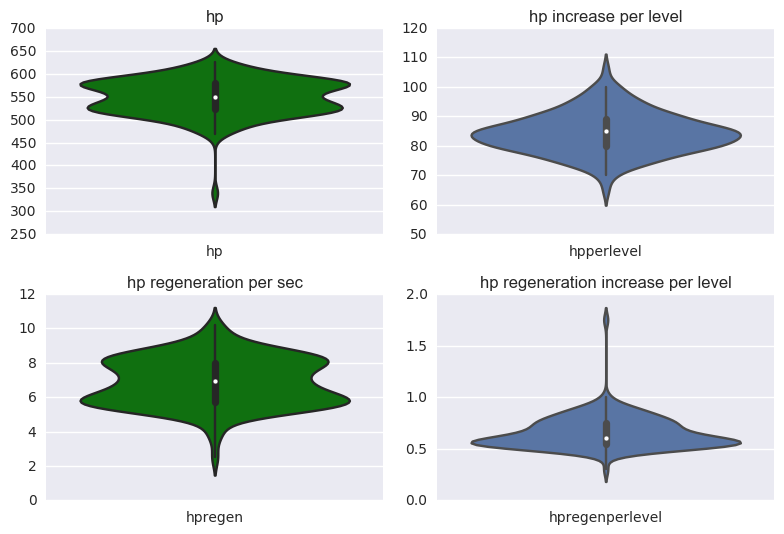

In [268]:
plt.subplot(2,2,1)
plt.title("hp")
sns.violinplot(df3[["hp"]],color = "green")
plt.subplot(2,2,2)
plt.title("hp increase per level")
sns.violinplot(df3[["hpperlevel"]])
plt.subplot(2,2,3)
plt.title("hp regeneration per sec")
sns.violinplot(df3[["hpregen"]], color = "green")
plt.subplot(2,2,4)
plt.title("hp regeneration increase per level")
sns.violinplot(df3[["hpregenperlevel"]])
plt.tight_layout()
plt.show()

In [269]:
HP = df3[["hp","hpperlevel","hpregen","hpregenperlevel"]]
HP.corr(method='pearson')

,hp,hpperlevel,hpregen,hpregenperlevel
hp,1.000000,0.682190,0.552504,0.309702
hpperlevel,0.682190,1.000000,0.474542,0.221856
hpregen,0.552504,0.474542,1.000000,0.365545
hpregenperlevel,0.309702,0.221856,0.365545,1.000000


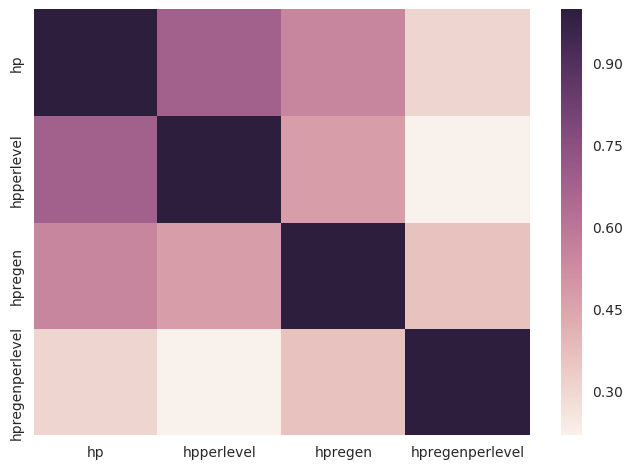

In [297]:
sns.heatmap(HP.corr(method='pearson'))
plt.show()

In [295]:
def correlation_p_value(data):
    a = [(x, y) for x in list(data) for y in list(data) if x != y]
    compare = list()
    for (x,y) in a:
        if (x, y) not in compare and (y, x) not in compare:
            compare.append((x, y))
    for (x, y) in compare:
        print x + " and " + y
        print scipy.stats.pearsonr(data[x], data[y])
        print "="*50

In [296]:
correlation_p_value(HP)

hp and hpperlevel
(0.6821900765410025, 4.378891792773511e-20)
hp and hpregen
(0.5525044891600337, 2.5683036444474798e-12)
hp and hpregenperlevel
(0.30970170339984615, 0.00023075828682034337)
hpperlevel and hpregen
(0.47454247987692116, 4.6778491164153352e-09)
hpperlevel and hpregenperlevel
(0.2218561078212575, 0.0091734961141551902)
hpregen and hpregenperlevel
(0.36554459795822664, 1.1211707508660931e-05)


All HP stats are positively and significantly correlated with each other. The range of starting HP varies widely (350 - 625). Majority of the champions have a total HP between 500 to 600 with a mean of 550. per level increase in HP also varied from 60 to 100 with a mean of 85. 

In [300]:
MP = df3[["mp","mpperlevel","mpregen","mpregenperlevel"]]
MP.aggregate(["min","median","mean","max"])

,mp,mpperlevel,mpregen,mpregenperlevel
min,0.000000,0.000000,0.000000,0.000000
median,307.200000,40.000000,7.000000,0.650000
mean,286.983212,36.748175,7.935752,0.557482
max,450.000000,67.000000,50.000000,1.000000


In [302]:
df3[df3["mp"]==0].shape
# 6 champion with a 0 for MP

(6, 21)

/Users/jasonchiu0803/anaconda2/lib/python2.7/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


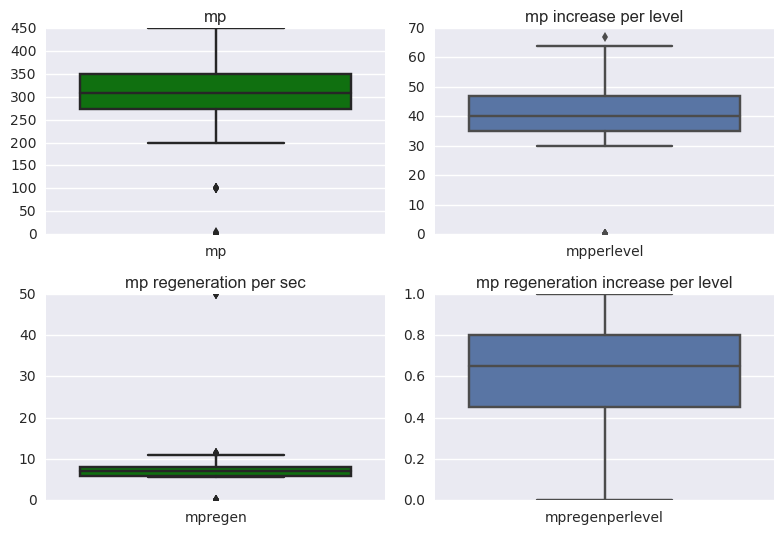

In [306]:
plt.subplot(2,2,1)
plt.title("mp")
sns.boxplot(MP[["mp"]],color = "green")
plt.subplot(2,2,2)
plt.title("mp increase per level")
sns.boxplot(MP[["mpperlevel"]])
plt.subplot(2,2,3)
plt.title("mp regeneration per sec")
sns.boxplot(MP[["mpregen"]], color = "green")
plt.subplot(2,2,4)
plt.title("mp regeneration increase per level")
sns.boxplot(MP[["mpregenperlevel"]])
plt.tight_layout()
plt.show()

In [307]:
MP[MP["mpregen"]>30]

,mp,mpperlevel,mpregen,mpregenperlevel
54,200.0,0.0,50.0,0.0
109,200.0,0.0,50.0,0.0
126,200.0,0.0,50.0,0.0
127,200.0,0.0,50.0,0.0
135,400.0,0.0,50.0,0.0


In [308]:
MP.corr(method='pearson')

,mp,mpperlevel,mpregen,mpregenperlevel
mp,1.000000,0.832441,0.161619,0.786493
mpperlevel,0.832441,1.000000,-0.157559,0.848782
mpregen,0.161619,-0.157559,1.000000,-0.170274
mpregenperlevel,0.786493,0.848782,-0.170274,1.000000


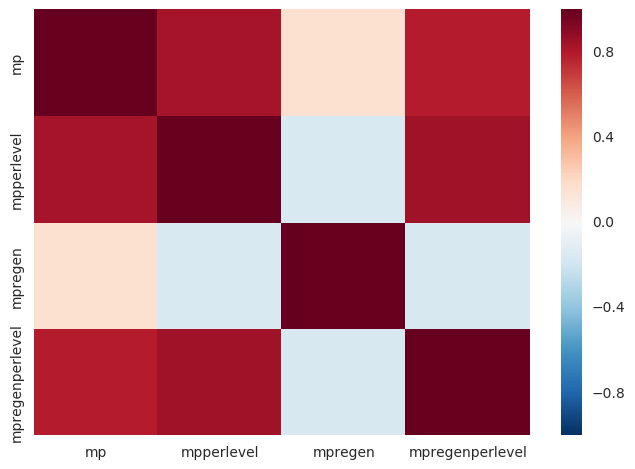

In [311]:
sns.heatmap(MP.corr(method='pearson'))
plt.show()

In [323]:
correlation_p_value(MP)

mp and mpperlevel
(0.83244079969293261, 1.9957337955104975e-36)
mp and mpregen
(0.16161857538456953, 0.059188872366053365)
mp and mpregenperlevel
(0.78649310186164778, 4.8276429559896768e-30)
mpperlevel and mpregen
(-0.15755934144964018, 0.065946083473565384)
mpperlevel and mpregenperlevel
(0.84878220521055814, 3.4989281577948175e-39)
mpregen and mpregenperlevel
(-0.17027372703906785, 0.046668819804868755)


MP has a very different distribution from HP - the distribution varied widely. Several champions (6) had zero mp and therefore, 0 for regeneration. On the other spectra, there were 5 heros that were able to regenerate 50 mp per second. All variables had positive correaltion with each other with the exception of mpregen and mp increase per level and mpregen and mp regeneration increase per level.

In [325]:
# both critical and critical per level only have a value of zero - This analysis will ignore these two variables. 
print(df3.crit.value_counts())
print(df3.critperlevel.value_counts())

0.0    137
Name: crit, dtype: int64
0.0    137
Name: critperlevel, dtype: int64


In [328]:
attack  = df3[["attackdamage", "attackdamageperlevel", "attackrange", 
               "attackspeedoffset","attackspeedperlevel","movespeed"]]

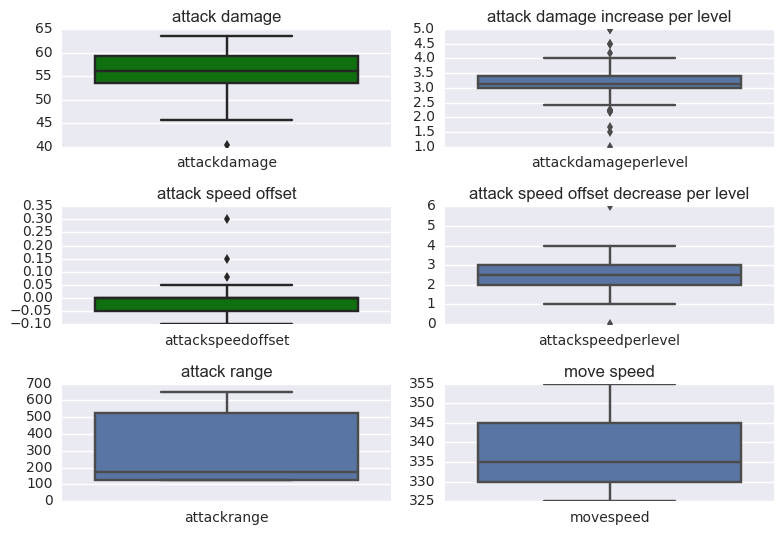

In [340]:
plt.subplot(3,2,1)
plt.title("attack damage")
sns.boxplot(attack[["attackdamage"]],color = "green")
plt.subplot(3,2,2)
plt.title("attack damage increase per level")
sns.boxplot(attack[["attackdamageperlevel"]])
plt.subplot(3,2,3)
plt.title("attack speed offset")
sns.boxplot(attack[["attackspeedoffset"]], color = "green")
plt.subplot(3,2,4)
plt.title("attack speed offset decrease per level")
sns.boxplot(attack[["attackspeedperlevel"]])
plt.subplot(3,2,5)
plt.title("attack range")
sns.boxplot(attack[["attackrange"]])
plt.ylim([0, 700])
plt.subplot(3,2,6)
plt.title("move speed")
sns.boxplot(attack[["movespeed"]])
plt.tight_layout()
plt.show()

In [341]:
attack.aggregate(["min","median","mean","max"])

,attackdamage,attackdamageperlevel,attackrange,attackspeedoffset,attackspeedperlevel,movespeed
min,40.368000,1.000000,125.000000,-0.100000,0.000000,325.000000
median,56.000000,3.141600,175.000000,0.000000,2.500000,335.000000
mean,55.967004,3.150961,316.824818,-0.018262,2.449321,336.445255
max,63.540000,5.000000,650.000000,0.300000,6.000000,355.000000


In [334]:
attack.corr()

,attackdamage,attackdamageperlevel,attackrange,attackspeedoffset,attackspeedperlevel,movespeed
attackdamage,1.000000,0.301147,-0.558115,-0.025732,-0.016763,0.412977
attackdamageperlevel,0.301147,1.000000,-0.462438,0.005369,-0.200334,0.268104
attackrange,-0.558115,-0.462438,1.000000,0.141949,-0.260044,-0.628851
attackspeedoffset,-0.025732,0.005369,0.141949,1.000000,-0.202176,-0.175860
attackspeedperlevel,-0.016763,-0.200334,-0.260044,-0.202176,1.000000,0.158608
movespeed,0.412977,0.268104,-0.628851,-0.175860,0.158608,1.000000


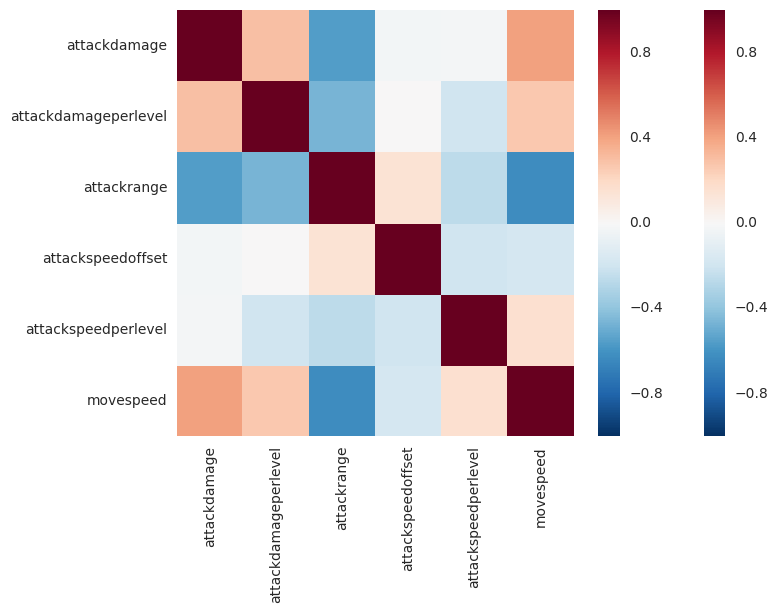

In [336]:
sns.heatmap(attack.corr())
plt.show()

In [337]:
correlation_p_value(attack)

attackdamage and attackdamageperlevel
(0.30114691388146519, 0.0003490001825875625)
attackdamage and attackrange
(-0.55811529286129846, 1.384600434258771e-12)
attackdamage and attackspeedoffset
(-0.025732408717905282, 0.76533694103215144)
attackdamage and attackspeedperlevel
(-0.016762956363480012, 0.84584603218588739)
attackdamage and movespeed
(0.41297728836492781, 5.2980458620349935e-07)
attackdamageperlevel and attackrange
(-0.46243786114712915, 1.27822647917103e-08)
attackdamageperlevel and attackspeedoffset
(0.0053691895967236686, 0.95034831544728249)
attackdamageperlevel and attackspeedperlevel
(-0.20033365592887684, 0.018914731629054153)
attackdamageperlevel and movespeed
(0.26810420428443615, 0.0015374309929564931)
attackrange and attackspeedoffset
(0.1419487495761502, 0.0979988168010196)
attackrange and attackspeedperlevel
(-0.260044425171092, 0.0021489966565464507)
attackrange and movespeed
(-0.62885146945954951, 1.9018399085077484e-16)
attackspeedoffset and attackspeedperlev

attack damage was mildly positively associated with movespeed, and negatively associated range. It has close to no assocaitoin with offset speed. offset speed has almost no correlation with other variables. attack range is negatively assocaited with movement speed. Attack damage had a range of 20, and movespeed had a range of 30. attack range varied greatly among champions. 

In [339]:
defense = df3[["armor","armorperlevel","spellblock","spellblockperlevel"]]

In [345]:
defense.corr()

,armor,armorperlevel,spellblock,spellblockperlevel
armor,1.000000,0.287071,0.704324,0.705152
armorperlevel,0.287071,1.000000,0.151986,0.151618
spellblock,0.704324,0.151986,1.000000,0.999845
spellblockperlevel,0.705152,0.151618,0.999845,1.000000


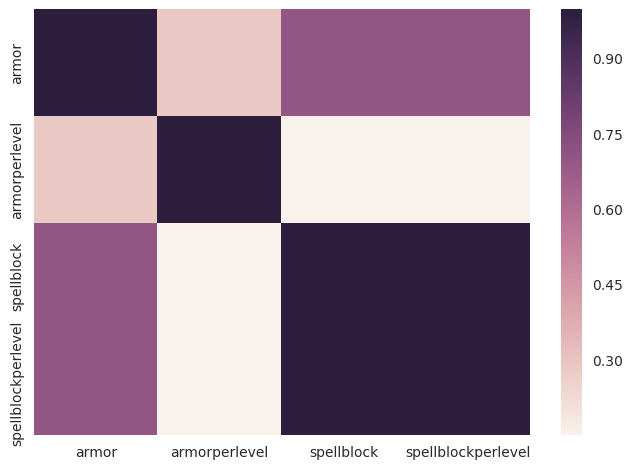

In [348]:
sns.heatmap(defense.corr())
plt.show()
# armor is very positively correlated with spellblock as well as spellblockperlevel
# spellblock and spellblockperlevel had an almost 1 correlation coefficient

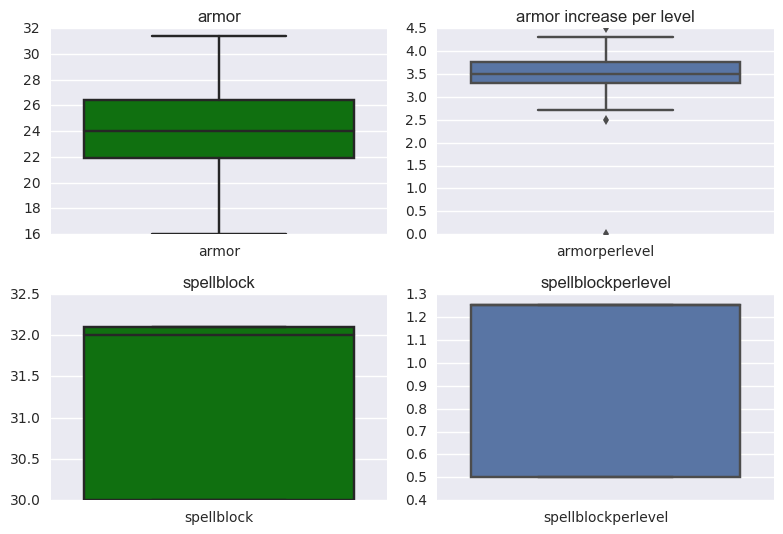

In [349]:
plt.subplot(2,2,1)
plt.title("armor")
sns.boxplot(defense[["armor"]],color = "green")
plt.subplot(2,2,2)
plt.title("armor increase per level")
sns.boxplot(defense[["armorperlevel"]])
plt.subplot(2,2,3)
plt.title("spellblock")
sns.boxplot(defense[["spellblock"]], color = "green")
plt.subplot(2,2,4)
plt.title("spellblockperlevel")
sns.boxplot(defense[["spellblockperlevel"]])
plt.tight_layout()
plt.show()
# while the armor starting stats varied widely, most of the armor increase were around 3 to 4.5 per level. 
# spellblock were pretty and increase per level are pretty consistent across all champions.

In [371]:
starting_stats = df3[["attackdamage","attackrange","movespeed" ,"mp", "hp","armor", "spellblock", "attackspeedoffset"]]

In [372]:
starting_stats.corr()

,attackdamage,attackrange,movespeed,mp,hp,armor,spellblock,attackspeedoffset
attackdamage,1.000000,-0.558115,0.412977,-0.289434,0.460532,0.474346,0.588422,-0.025732
attackrange,-0.558115,1.000000,-0.628851,0.348937,-0.664105,-0.696737,-0.912377,0.141949
movespeed,0.412977,-0.628851,1.000000,-0.248336,0.410850,0.469727,0.601134,-0.175860
mp,-0.289434,0.348937,-0.248336,1.000000,-0.226981,-0.161220,-0.325358,0.099584
hp,0.460532,-0.664105,0.410850,-0.226981,1.000000,0.574273,0.660827,-0.146441
armor,0.474346,-0.696737,0.469727,-0.161220,0.574273,1.000000,0.704324,-0.083479
spellblock,0.588422,-0.912377,0.601134,-0.325358,0.660827,0.704324,1.000000,-0.122325
attackspeedoffset,-0.025732,0.141949,-0.175860,0.099584,-0.146441,-0.083479,-0.122325,1.000000


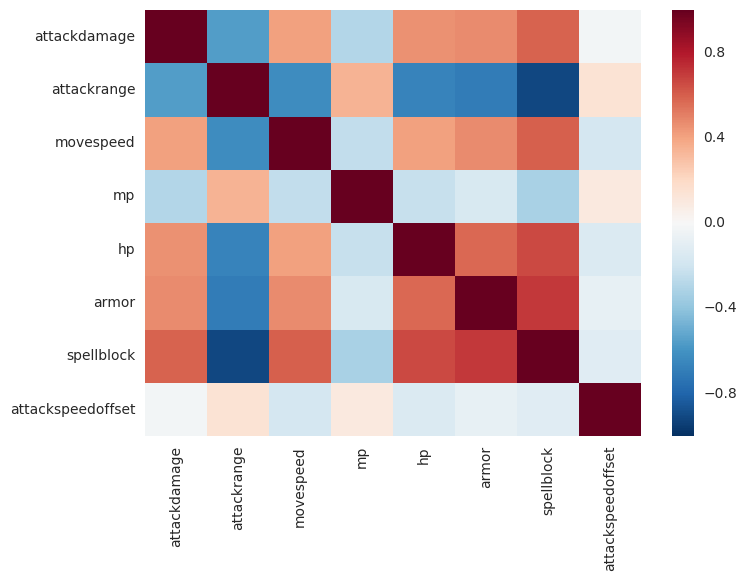

In [373]:
sns.heatmap(starting_stats.corr())
plt.show()

common patterns:
    1. attackspeed is not relating to any other starting stats
    2. higher attack damage more likely to have spellblock as well
    3. armor is strongly positively associated hp and spellblock
    4. attackrange is negatively associated with attackdamage, armor, hp, movespeed, and highly negatively associated with spellblock
    5. movement speed is positively associated with spellblock
    6. similar patterns between spellblock, armor, and hp
    7. attak damage and movespeed are opposite of attackrange

In [359]:
df3.drop(["crit","critperlevel"],axis = 1,inplace= True)

In [374]:
df = pd.merge(df, df3, how = "inner", on = "id")

In [494]:
df4 = pd.read_sql_query("""SELECT * FROM spells""", conn)

In [495]:
list(df4)

['id',
 'spell1_labels',
 'spell2_labels',
 'spell3_labels',
 'spell4_labels',
 'spell1_lv1_effect',
 'spell1_lv2_effect',
 'spell1_lv3_effect',
 'spell1_lv4_effect',
 'spell1_lv5_effect',
 'spell1_lv6_effect',
 'spell2_lv1_effect',
 'spell2_lv2_effect',
 'spell2_lv3_effect',
 'spell2_lv4_effect',
 'spell2_lv5_effect',
 'spell2_lv6_effect',
 'spell3_lv1_effect',
 'spell3_lv2_effect',
 'spell3_lv3_effect',
 'spell3_lv4_effect',
 'spell3_lv5_effect',
 'spell3_lv6_effect',
 'spell4_lv1_effect',
 'spell4_lv2_effect',
 'spell4_lv3_effect',
 'spell4_lv4_effect',
 'spell4_lv5_effect',
 'no_spells',
 'spell1_costType',
 'spell1_maxrank',
 'spell1_description',
 'spell1_name',
 'spell2_costType',
 'spell2_maxrank',
 'spell2_description',
 'spell2_name',
 'spell3_costType',
 'spell3_maxrank',
 'spell3_description',
 'spell3_name',
 'spell4_costType',
 'spell4_maxrank',
 'spell4_description',
 'spell4_name',
 'spell1_lv1_cooldown',
 'spell1_lv2_cooldown',
 'spell1_lv3_cooldown',
 'spell1_lv4_cool

In [496]:
filter_col = [col for col in list(df4) if col.endswith('cooldown') or col.endswith('cost') or col.endswith("range") or col.endswith("maxrank") or col.endswith("effect")] + ["id"] 

In [497]:
spells_num = df4[filter_col]

In [499]:
spells_num.head(2)

,spell1_lv1_effect,spell1_lv2_effect,spell1_lv3_effect,spell1_lv4_effect,spell1_lv5_effect,spell1_lv6_effect,spell2_lv1_effect,spell2_lv2_effect,spell2_lv3_effect,spell2_lv4_effect,...,spell4_lv2_cost,spell4_lv3_cost,spell4_lv4_cost,spell4_lv5_cost,spell4_lv1_range,spell4_lv2_range,spell4_lv3_range,spell4_lv4_range,spell4_lv5_range,id
0,80.0,115.0,150.0,185.0,220.0,NaN,70.0,115.0,160.0,205.0,...,100.0,100.0,NaN,NaN,600,600.0,600.0,NaN,NaN,1
1,60.0,110.0,160.0,210.0,260.0,NaN,60.0,105.0,150.0,195.0,...,0.0,0.0,NaN,NaN,900,900.0,900.0,NaN,NaN,10


In [500]:
def getting_row_avg(spellnumber, spelltype):
    names = list(spells_num)
    return spells_num[[col for col in names if col.startswith(spellnumber) and col.endswith(spelltype)]].mean(axis=1)

In [429]:
spells_num[["spell1_lv1_range","spell1_lv2_range"]].head(2)

,spell1_lv1_range,spell1_lv2_range
0,625,625
1,650,650


In [501]:
spells_num[["spell1_lv1_range","spell1_lv2_range"]].sum(axis = 1).head(2)

0    1250
1    1300
dtype: int64

In [518]:
spells_num["spell1_avg_range"] = getting_row_avg("spell1","range")
spells_num["spell1_avg_cooldown"] = getting_row_avg("spell1","cooldown")
spells_num["spell1_avg_cost"] = getting_row_avg("spell1","cost")
spells_num["spell1_avg_effect"] = getting_row_avg("spell1","effect")
spells_num["spell2_avg_range"] = getting_row_avg("spell2","range")
spells_num["spell2_avg_cooldown"] = getting_row_avg("spell2","cooldown")
spells_num["spell2_avg_cost"] = getting_row_avg("spell2","cost")
spells_num["spell2_avg_effect"] = getting_row_avg("spell2","effect")
spells_num["spell3_avg_range"] = getting_row_avg("spell3","range")
spells_num["spell3_avg_cooldown"] = getting_row_avg("spell3","cooldown")
spells_num["spell3_avg_cost"] = getting_row_avg("spell3","cost")
spells_num["spell3_avg_effect"] = getting_row_avg("spell3","effect")
spells_num["spell4_avg_range"] = getting_row_avg("spell4","range")
spells_num["spell4_avg_cooldown"] = getting_row_avg("spell4","cooldown")
spells_num["spell4_avg_cost"] = getting_row_avg("spell4","cost")
spells_num["spell4_avg_effect"] = getting_row_avg("spell4","effect")

/Users/jasonchiu0803/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/jasonchiu0803/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/jasonchiu0803/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [523]:
spells_num.loc[spells_num["spell1_avg_range"]==0, "spell1_avg_effect"] = 0
spells_num.loc[spells_num["spell2_avg_range"]==0, "spell2_avg_effect"] = 0
spells_num.loc[spells_num["spell3_avg_range"]==0, "spell3_avg_effect"] = 0

In [524]:
spells_final = spells_num[[col for col in list(spells_num) if "avg" in col or col.endswith("maxrank")] + ["id"]]

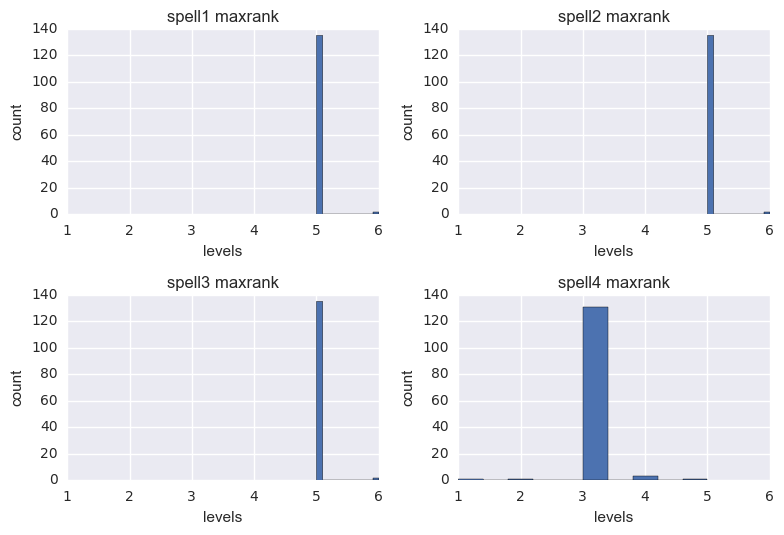

In [525]:
plt.subplot(2,2,1)
plt.title("spell1 maxrank")
plt.hist(spells_final["spell1_maxrank"])
plt.xlim([1,6])
plt.xlabel("levels")
plt.ylabel("count")
plt.subplot(2,2,2)
plt.title("spell2 maxrank")
plt.hist(spells_final["spell2_maxrank"])
plt.xlim([1,6])
plt.xlabel("levels")
plt.ylabel("count")
plt.subplot(2,2,3)
plt.title("spell3 maxrank")
plt.hist(spells_final["spell3_maxrank"])
plt.xlim([1,6])
plt.xlabel("levels")
plt.ylabel("count")
plt.subplot(2,2,4)
plt.title("spell4 maxrank")
plt.hist(spells_final["spell4_maxrank"])
plt.xlim([1,6])
plt.xlabel("levels")
plt.ylabel("count")
plt.tight_layout()
plt.show()

In [517]:
spells_final[[col for col in list(spells_final) if not col.endswith("maxrank")]].aggregate(["min","mean","median","max"])

,spell1_avg_range,spell1_avg_cooldown,spell1_avg_cost,spell1_avg_effect,spell2_avg_range,spell2_avg_cooldown,spell2_avg_cost,spell3_avg_range,spell3_avg_cooldown,spell3_avg_cost,spell4_avg_range,spell4_avg_cooldown,spell4_avg_cost,spell2_avg_effect,spell3_avg_effect,spell4_avg_effect,id
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000
mean,1248.364964,7.698905,50.182482,117.841241,932.912409,12.337348,49.839416,1009.386861,10.526764,52.018248,3863.605839,92.61983,76.180049,83.670438,90.167883,244.033577,105.693431
median,700.000000,7.000000,55.000000,110.000000,600.000000,12.000000,55.000000,625.000000,11.000000,60.000000,700.000000,100.00000,100.000000,50.000000,100.000000,175.000000,78.000000
max,25000.000000,18.000000,120.000000,875.000000,25000.000000,90.000000,100.000000,25000.000000,50.000000,150.000000,50000.000000,180.00000,175.000000,1500.000000,450.000000,5500.000000,498.000000


In [526]:
list(spells_final)

['spell1_maxrank',
 'spell2_maxrank',
 'spell3_maxrank',
 'spell4_maxrank',
 'spell1_avg_range',
 'spell1_avg_cooldown',
 'spell1_avg_cost',
 'spell1_avg_effect',
 'spell2_avg_range',
 'spell2_avg_cooldown',
 'spell2_avg_cost',
 'spell3_avg_range',
 'spell3_avg_cooldown',
 'spell3_avg_cost',
 'spell4_avg_range',
 'spell4_avg_cooldown',
 'spell4_avg_cost',
 'spell2_avg_effect',
 'spell3_avg_effect',
 'spell4_avg_effect',
 'id']

potential ideas - since there are no categories for reasons for the orders of these spells + the labels/tags are pretty complicated - we might be able to do some sort of clustering with the spells to get the type of it down and compare with the labels.

In [527]:
df = pd.merge(df, spells_final, how = "inner", on = "id")

In [531]:
df.drop(["crit","critperlevel"],inplace=True, axis = 1)

# Categorical/text data cleanup

In [ ]:
cur.close()
conn.close()